# Prognositc (trajectory prediction) performance of baseline ML models on ADNI2 longitudinal data

* **Objectives:** 
    1. Predict Trajectory classes based on structural features
    2. Predict Trajectory classes based on structural features + baseline clinical score + demographics


* **Input modalities:**
    1. Coritcal thickness (CT)
    2. Hippocampal subfield volumes (HC) 


* **Models:**
    1. Logistic regression (Lasso)
    2. SVM
    3. Random Forest
    
    
* **Code organization:**
    1. Stage 1: 
        1. Import raw data, and setup CV folds based on choice of input features 
        2. Save this experimental setup to disk
        
    2. Stage 2:
        1. Train and test ML models over k-fold setup (Parallelized implmentation)
        2. Plot and save performance results 

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
from scipy import stats
import pickle
import re
import collections
#import tables as tb
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import KFold

%matplotlib inline
#plt.rcParams['figure.figsize'] = (15, 10)
#plt.style.use('ggplot')

/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Some Defs
def load_data(data_path, input_node, preproc):
    data = tb.open_file(data_path, 'r')
    X_raw = data.get_node('/' + input_node)[:]
    if preproc == 'scale':
        X = preprocessing.scale(X_raw)
    elif preproc == 'norm_max':
        X = preprocessing.normalize(X_raw, norm='max')
    elif preproc == 'norm_l2':
        X = preprocessing.normalize(X_raw, norm='l2')
    else:
        X = X_raw
    data.close()
    return X

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f)
    f.close()

#Outer Fold Computation (need the imports inside def if you want to parallelize!)
def computeOuterFold(train_X, train_y, valid_X, valid_y, Sub_train, Sub_valid, model_clf, hyper_params, output_type, model_type):    
    import collections
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    import datetime
    import time
    import collections
    from scipy.stats import mode
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from scipy import stats
    import numpy as np
    
    print 'Starting Outerfold computation'
    
    hp_dict = collections.defaultdict(list) #store best hyper-parameters for each fold
    inner_loop = True
    if inner_loop:     
        print 'Starting InnerFold computation'        
        clf = innerCVLoop(model_clf,hyper_params,train_X, train_y)
        for hp in hyper_params:
            hp_dict[hp].append(clf.best_estimator_.get_params()[hp])
            
        print 'Ending InnerFold computation'

    else:
        clf = model_clf
        clf.fit(fold_X,fold_y)
        
    if output_type == 'classify':
        pred_y = clf.predict(valid_X) #Specific label value
        pred_y_prob = clf.predict_proba(valid_X) #Label probabilty (used for ROC)

        #feature imp (issue with the innerCVLoop)
        if model_type == 'RFC':
            feat_imp = clf.best_estimator_.feature_importances_
        elif model_type == 'LR_L1':
            feat_imp = clf.best_estimator_.coef_ 
        else: 
            print "Unknown model for computing feature importance. Setting it to zeros"
            feat_imp = np.zeros(len(pred_y))

        print 'Ending OuterFold computation'

        return_dict = {'actual_fold_scores':valid_y, 'predicted_fold_prob':pred_y_prob, 'predicted_fold_score': pred_y, 
                'hp_dict':hp_dict, 'feat_imp': feat_imp,'Sub_train':Sub_train,'Sub_valid':Sub_valid}
    
    else: 
        print 'unknown output_type'

    print 'Ending OuterFold computation'
    
    return return_dict

#Inner Fold Computation (need the imports inside def if you want to parallelize!)
def innerCVLoop(model_clf,hyper_params,fold_X, fold_y):
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import grid_search
    clf = grid_search.GridSearchCV(model_clf, hyper_params,cv=3,verbose=0)
    clf.fit(fold_X, fold_y)   
    return clf

def autolabel(rects,_ax):
    for rect in rects:
        height = rect.get_height()
        _ax.text(rect.get_x() + rect.get_width()/2., 1.1*height,
                '{:03.2f}'.format(height),
                ha='center',            # vertical alignment
                va='bottom',             # horizontal alignment
                fontsize = 35)

## Stage 1

In [64]:
# Data imports
baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'

#Exp series:
#1xx: All subjects, 2xx:CN and AD excluded
my_name = 'Exp_102'
cohort = 'ADNI2'
tp_name = 'var_tp' #bl or var_tp
clinical_scale = 'MMSE' #For trajectory definitions
mci_only = False

input_csv = '{}_{}.csv'.format(cohort,tp_name)
in_data = pd.read_csv(baseline_dir + input_csv)

#Exclude certain subjects (based on DX_bl usually)
if mci_only:
    print 'excluding CN and AD subjects'
    in_data = in_data[~in_data['DX_bl'].isin(['CN','AD'])]

traj_csv = 'ADNI_trajectory_labels_MMSE_4cstp_autoselect.csv'
traj_data = pd.read_csv(baseline_dir + traj_csv)

exp_name = '{}_{}_traj_{}_tp_{}'.format(my_name,cohort,clinical_scale,tp_name)

print 'exp_name: {}'.format(exp_name)
print 'subx, MR+CS:{}, traj: {}'.format(len(in_data),len(traj_data))

#Merge MR + traj data
input_traj_merge_data = pd.merge(in_data,traj_data[['PTID','traj']],on='PTID',how='inner')
print 'merge subx: {}'.format(len(input_traj_merge_data))

ct_cols = list(in_data.columns[pd.Series(in_data.columns).str.contains('CT')])
demo_cols = ['AGE','APOE4']

excluding CN and AD subjects
exp_name: Exp_202_ADNI2_traj_MMSE_tp_var_tp
subx, MR+CS:316, traj: 1624
merge subx: 315


In [66]:
#Stratified K-fold for the stack
save_experimental_setup = False
X = np.array(input_traj_merge_data[ct_cols].values)
y = np.array(input_traj_merge_data['traj'].values)
sKF = StratifiedKFold(y, n_folds=10)
for train_index, test_index in sKF:    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print 'y distribution: train:{},{}, test:{},{}'.format(np.sum(y_train==0),np.sum(y_train==1),
                                                           np.sum(y_test==0),np.sum(y_test==1))
    
save_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'    
print 'Saving exp_setup to: {}'.format(save_path)
if save_experimental_setup:    
    exp_setup = {'exp_name':exp_name,'df':input_traj_merge_data,'sKF':sKF}
    pickleIt(exp_setup, save_path)        

y distribution: train:187,96, test:21,11
y distribution: train:187,96, test:21,11
y distribution: train:187,96, test:21,11
y distribution: train:187,96, test:21,11
y distribution: train:187,96, test:21,11
y distribution: train:187,96, test:21,11
y distribution: train:187,96, test:21,11
y distribution: train:187,97, test:21,10
y distribution: train:188,97, test:20,10
y distribution: train:188,97, test:20,10
Saving exp_setup to: /projects/nbhagwat/Traj_prediction/ADNI/exp_setup/KFolds/Exp_202_ADNI2_traj_MMSE_tp_var_tp_sKF.pkl


# Stage 2

In [3]:
# Configs for K-fold validations (nested)
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
import datetime
import time
import collections
from scipy.stats import mode
from sklearn.metrics import mean_squared_error as mse
from functools import partial #Parallelize!!! 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
from sklearn.metrics import accuracy_score as acc
import ipyparallel as ipp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
import pickle
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.over_sampling import SMOTE
# from imblearn.over_sampling import ADASYN #For treating class imbalance
from functools import partial #Parallelize!!! 
import time 

/projects/nbhagwat/ADNI_prediction/code/conda_envs/AD_traj_hopper/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
#Pick model with its configs/hyper-paramsd
def getModel(model_choice,output_type): 
    if output_type == 'regression' :
        if model_choice == 'LR_L1':
            model_clf = Lasso()
            hyper_params = {'alpha':[1, 0.5, 0.1, 0.05, 0.01]} 
            scale_data = True #Scales HC and CT features    
            feat_imp = False   

        elif model_choice == 'SVR':
            model_clf = SVR()
            hyper_params = {'kernel':['linear','rbf'], 'C':[1,10,25]}
            scale_data = True #Scales HC and CT features        
            feat_imp = False

        elif model_choice == 'RFR':
            model_clf = RandomForestRegressor(n_jobs=4)
            hyper_params = {'n_estimators':[10,50,100,200],'min_samples_split':[2,4,8]}    
            scale_data = False    
            feat_imp = False   
        else:
            print "Unknown model choice"
    
    elif output_type =='classify':
        if model_choice == 'LR_L1':
            model_clf = LogisticRegression(penalty='l1',n_jobs=4,class_weight='balanced')
            hyper_params = {'C':[1e-3,1e-2,1e-1,1,1e1]} 
            scale_data = True #Scales features (z-score)            
            shift_labels = False
            feat_imp = False #The learned weights of each variable

        elif model_choice == 'SVC':
            model_clf = SVC(class_weight='balanced',probability=True)
            hyper_params = {'kernel':['linear'], 'C':[1e-3,1e-2,1e-1,1,1e1,1e2]}
            scale_data = True #Scales HC and CT features            
            shift_labels = True
            feat_imp = False

        elif model_choice == 'RFC':    
            model_clf = RandomForestClassifier(n_jobs=4,class_weight='balanced' )
            hyper_params = {'n_estimators':[10,50,75,100,150],'min_samples_split':[2,4,8]}    
            scale_data = False            
            shift_labels = False
            feat_imp = True   #RF oob based feature importance

        else:
            print "Unknown model choice"
    
    else: 
        print 'Unknown output type'

    return {'model_clf':model_clf,'hyper_params':hyper_params,'scale_data':scale_data,'shift_labels':shift_labels,
            'feat_imp':feat_imp}

def computePerfMetrics(perf_df,dx_list): 
    CV_summary_df = pd.DataFrame(columns=['model','kf','Accuracy','AUC','CM'])
    idx=1    
    for model_choice in set(perf_df['model'].values):        
        CV_Acc = []
        CV_AUC = []
        CV_CM = []        
        for k in np.arange(1,11,1):            
            df_dx_subset = perf_df[(perf_df['DX_bl'].isin(dx_list))&(perf_df['kf']==k)&(perf_df['model']==model_choice)]            
            y_act = df_dx_subset['act_label'].values
            y_pred_score = df_dx_subset['pred_label'].values
            y_pred_prob = np.vstack(df_dx_subset['pred_prob'].values)

            CV_Acc.append(acc(y_pred_score,y_act))                
            CV_AUC.append(roc_auc_score(y_act, y_pred_prob[:,1]))
            cm = confusion_matrix(y_pred_score,y_act)
            cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
            CV_CM.append(cm_normalized)             
            
            CV_summary_df.set_value(idx,'model',model_choice) 
            CV_summary_df.set_value(idx,'kf',k) 
            CV_summary_df.set_value(idx,'Accuracy',acc(y_pred_score,y_act))  
            CV_summary_df.set_value(idx,'AUC',roc_auc_score(y_act, y_pred_prob[:,1])) 
            CV_summary_df.set_value(idx,'CM',cm_normalized)             
            idx+=1
                        
        print model_choice
        print 'CV Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc),stats.sem(CV_Acc))
        print 'CV AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC),stats.sem(CV_AUC))
        print 'CV Confusion Matrix (mean): {}'.format(np.mean(np.array(CV_CM),axis=0))
        
    return CV_summary_df
           

In [26]:
# Train and Test models
# Load saved experimental setup

baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'
demo_cols = ['AGE','APOE4']

exp_name = 'Exp_102_ADNI2_traj_MMSE_tp_var_tp'
use_cs = True
use_ct = True
var_tp = True
shuffle_labels = False # What's your performance with random labels. 

# Oversampling options
resample_train_data = False
sampling_tech = 'smote'

exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )

#Check if loading the correct experimental setup
if exp_name != exp_setup['exp_name']:
    print 'Incorrect exp_name. Selected:{}, Retrieved:{}'.format(exp_name, exp_setup['exp_name'])

else:
    print 'exp_name: {}'.format(exp_name)
    
    df = exp_setup['df']
    kf = exp_setup['sKF']
    
    feat_cols = []
    feat_sufix = ''
        
    if use_cs:
        print 'using CS columns'
        if var_tp:
            cs_cols = ['MMSE_bl','MMSE_var_tp'] + demo_cols
        else:
            cs_cols = ['MMSE_bl'] + demo_cols
        feat_cols = feat_cols + cs_cols
        feat_sufix = feat_sufix + '_CS'
        
    if use_ct: 
        print 'using CT columns'
        if var_tp:
            ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
            ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_rate')])
            ct_cols = ct_cols_bl + ct_cols_tp_rate
        else:
            ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])
        
        feat_cols = feat_cols + ct_cols
        feat_sufix = feat_sufix + '_CT'    
    
    #print feat_cols
    
    # Model options
    model_list = ['LR_L1','SVC','RFC']
    output_type = 'classify' #needs to be either 'classify' or 'regression'

    save_CV_perf = False 

    ########################
    # Parallization configs for ipython notebook cluster    
    rc = ipp.Client()
    dview = rc[:]
    dview.push(dict(computeOuterFold = computeOuterFold))
    dview.push(dict(innerCVLoop = innerCVLoop))
    ########################

    df_perf_dict = {}
    df_perf_concat = pd.DataFrame(columns=['PTID','model','kf','act_label','pred_label','pred_prob'])
    idx = 1
    ####################
    ## Select a model ##
    ####################       
    for model_choice in model_list:
        model_def = getModel(model_choice,output_type)
        model_clf = model_def['model_clf']
        hyper_params = model_def['hyper_params']
        scale_data = model_def['scale_data']    
        shift_labels = model_def['shift_labels']    
        feat_imp = model_def['feat_imp']

        X_raw = np.array(df[feat_cols]) #Otherwise scaling and shifting will remain the same for next model. 
        y = np.array(df['traj'])     
        if shuffle_labels:
            print 'shuffling labels'
            np.random.shuffle(y)

        if shift_labels:
            y = 2*y-1 #SVM requires {-1,1}

        print 'model: {}, X shape {}'.format(model_choice, X_raw.shape)
        #Some paths to store models and performance stats
        CV_model_dir = baseline_dir + 'output/'
        save_model_path = CV_model_dir + exp_name + '_' + model_choice 
        save_model = False 

        # Create list of all the fold-subsets (needed for parallelization)
        Sub_train =[]
        Sub_valid = []
        X_train = []
        X_valid = []
        y_train = []
        y_valid = []    
        
        start_time = time.time()
        for train, valid in kf:
            Sub_train.append(df['PTID'].values[train]) 
            Sub_valid.append(df['PTID'].values[valid]) 
            X_tr = X_raw[train]
            y_tr = y[train]
            X_te = X_raw[valid]
            y_te = y[valid]

            if scale_data:
                scaler = preprocessing.StandardScaler().fit(X_tr)
                X_tr = scaler.transform(X_tr)
                X_te = scaler.transform(X_te)

            if resample_train_data:             
                #resample with tools from: https://github.com/scikit-learn-contrib/imbalanced-learn
                if sampling_tech == 'adasyn':                    
                    resamp_tech = ADASYN()
                elif sampling_tech == 'smote':
                    resamp_tech = SMOTE(kind='regular')
                else:
                    resamp_tech = RandomOverSampler()

                print 'using {} oversampling technique'.format(sampling_tech)                    
                X_resampled, y_resampled = resamp_tech.fit_sample(X_tr, y_tr)
                #print 'Original shapes: X{}, y:{}, y==1: {}'.format(X[train].shape, y[train].shape, np.sum(y[train]))
                #print 'Resampled shapes: X{}, y:{}, y==1: {}'.format(X_resampled.shape, y_resampled.shape, np.sum(y_resampled))                
                X_train.append(X_resampled)
                y_train.append(y_resampled)
            else:
                X_train.append(X_tr)
                y_train.append(y_tr)

            # No need to resample test data
            X_valid.append(X_te)            
            y_valid.append(y_te)

        # Compute various statistics on the predicted results acorss 10 Folds            
        if output_type == 'classify':        
            CV_Acc_valid=[] #Acuracy
            CV_CM_valid=[] #Confusion matrix
            CV_AUC_valid=[] #ROC and AUC                   
            CV_feat_imp = []
        else: 
            print 'unknown output type'

        predicted_CV_scores = []
        actual_CV_scores = []

        #Parallelize k-folds
        mapfunc = partial(computeOuterFold, model_clf=model_clf, hyper_params=hyper_params, 
                          output_type=output_type, model_type=model_choice)
        parallel_result = dview.map_sync(mapfunc, X_train, y_train, X_valid, y_valid,Sub_train,Sub_valid)    

        hp_dict = collections.defaultdict(list)
        for p, pr in enumerate(parallel_result):   
            df_perf = pd.DataFrame()
            if output_type == 'classify':
                y_pred_score = pr['predicted_fold_score']
                y_pred_prob = pr['predicted_fold_prob']
                y_act = pr['actual_fold_scores']
                predicted_CV_scores.append(y_pred_score)
                actual_CV_scores.append(y_act)        

                #Acc    
                CV_accuracy = acc(y_pred_score,y_act)
                CV_Acc_valid.append(CV_accuracy)                

                #AUC                
                CV_auc = roc_auc_score(y_act, y_pred_prob[:,1])
                CV_AUC_valid.append(CV_auc)

                #confusion matrix
                cm = confusion_matrix(y_pred_score,y_act)
                cm_normalized = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
                CV_CM_valid.append(cm_normalized)
                
                #Save perf method 1: df of all subjects
                df_perf['PTID'] = pr['Sub_valid']
                df_perf['model'] = np.tile(model_choice,len(y_act))
                df_perf['kf'] = np.tile(p+1,len(y_act))
                df_perf['act_label'] = y_act
                df_perf['pred_label'] = y_pred_score
                df_perf['pred_prob'] = list(y_pred_prob)
                
                df_perf_concat = df_perf_concat.append(df_perf)
                
                #Save perf method 2: dictionary of k folds
                df_perf_dict[idx] = {'model_choice':model_choice,'KF':p+1, 'act_scores':y_act,
                                    'pred_scores':y_pred_score,'pred_prob':y_pred_prob, 'Accuracy':CV_accuracy,
                                    'AUC':CV_auc,'CM':cm_normalized}
                idx+=1

            for hp in hyper_params:
                hp_dict[hp].append(pr['hp_dict'][hp])

        #Find out most frequent hyper-params during cross-val    
        hp_mode = {}
        for hp in hyper_params:
            hp_mode[hp] = mode(hp_dict[hp])[0][0]
        
        if output_type == 'classify':
            print 'most frequent hyper-params:' + str(hp_mode)
            print 'CV Acc (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_Acc_valid),stats.sem(CV_Acc_valid))
            print 'CV AUC (mean, std_err): {:04.2f}, {:04.2f}'.format(np.mean(CV_AUC_valid),stats.sem(CV_AUC_valid))
            print 'CV Confusion Matrix (mean): {}'.format(np.mean(np.array(CV_CM_valid),axis=0))
           
            plot_name = 'ROC'
        
        #timer
        end_time = time.time()
        compute_time = (end_time - start_time)/60.0
        print 'compute time: {}, {:3.2f} mins'.format(model_choice,compute_time)
        print ''
        
    #Save df style dictionaly for seaborn plots
    # df_perf_dict_path = baseline_dir + 'df_perf_dict_{}_{}.pkl'.format(exp_name, Clinical_Scale)                
    # pickleIt(df_perf_dict,df_perf_dict_path)
    # print 'saving results at: {}'.format(df_perf_dict_path)

exp_name: Exp_102_ADNI2_traj_MMSE_tp_var_tp
using CS columns
using CT columns
model: LR_L1, X shape (566, 160)
most frequent hyper-params:{'C': array([ 0.1])}
CV Acc (mean, std_err): 0.90, 0.01
CV AUC (mean, std_err): 0.96, 0.01
CV Confusion Matrix (mean): [[ 0.93082998  0.06917002]
 [ 0.13641257  0.86358743]]
compute time: LR_L1, 0.03 mins

model: SVC, X shape (566, 160)
most frequent hyper-params:{'kernel': array(['linear'], 
      dtype='|S6'), 'C': array([ 0.01])}
CV Acc (mean, std_err): 0.89, 0.01
CV AUC (mean, std_err): 0.95, 0.01
CV Confusion Matrix (mean): [[ 0.91310585  0.08689415]
 [ 0.15022566  0.84977434]]
compute time: SVC, 0.07 mins

model: RFC, X shape (566, 160)
most frequent hyper-params:{'n_estimators': array([75]), 'min_samples_split': array([2])}
CV Acc (mean, std_err): 0.87, 0.02
CV AUC (mean, std_err): 0.94, 0.01
CV Confusion Matrix (mean): [[ 0.85969543  0.14030457]
 [ 0.11799658  0.88200342]]
compute time: RFC, 1.26 mins



In [27]:
#Save df and dictionaries for seaborn plots
perf_dict_path = baseline_dir + 'perf_stats/df_perf_dict_{}_feat{}_dict.pkl'.format(exp_name,feat_sufix)                
perf_df_path = baseline_dir + 'perf_stats/df_perf_dict_{}_feat{}_df.pkl'.format(exp_name,feat_sufix)                
pickleIt(df_perf_dict,perf_dict_path)
df_perf_concat.to_pickle(perf_df_path)

print 'saving results at: {}'.format(perf_df_path)

saving results at: /projects/nbhagwat/Traj_prediction/ADNI/exp_setup/perf_stats/df_perf_dict_Exp_102_ADNI2_traj_MMSE_tp_var_tp_feat_CS_CT_df.pkl


In [212]:
# Compute per DX_list performances 
#Load multiple perf_dfs

df_subx_perf_paths = {'tp: bl, feat: cs':'df_perf_dict_Exp_101_ADNI2_traj_MMSE_tp_bl_feat_CS_df.pkl',
                      'tp: bl, feat: cs+ct':'df_perf_dict_Exp_101_ADNI2_traj_MMSE_tp_bl_feat_CS_CT_df.pkl',
                      'tp: bl+1, feat: cs':'df_perf_dict_Exp_102_ADNI2_traj_MMSE_tp_var_tp_feat_CS_df.pkl',
                      'tp: bl+1, feat: cs+ct':'df_perf_dict_Exp_102_ADNI2_traj_MMSE_tp_var_tp_feat_CS_CT_df.pkl'}

dx_list_cnad = ['AD','CN']
dx_list_mci = ['SMC','EMCI','LMCI']
dx_list_all = ['CN','SMC','EMCI','LMCI','AD']

CV_summary_df = pd.DataFrame()
for exp_idx in df_subx_perf_paths:
    print 'exp_idx: ' + exp_idx
    perf_df_path = baseline_dir + 'perf_stats/{}'.format(df_subx_perf_paths[exp_idx])                
    df_perf_concat = pickle.load( open(perf_df_path, "rb" ) )
    df_perf_dx_merge = pd.merge(df_perf_concat,df[['PTID','DX_bl']],on='PTID',how='inner')

    CV_summary_df_cnad = computePerfMetrics(df_perf_dx_merge,dx_list_cnad)
    CV_summary_df_cnad['DX_subset']=np.tile('cn+ad',len(CV_summary_df_cnad))
    CV_summary_df_mci = computePerfMetrics(df_perf_dx_merge,dx_list_mci)
    CV_summary_df_mci['DX_subset']=np.tile('smc+mci',len(CV_summary_df_mci))
    CV_summary_df_all = computePerfMetrics(df_perf_dx_merge,dx_list_all)
    CV_summary_df_all['DX_subset']=np.tile('all',len(CV_summary_df_all))

    CV_summary_df_feat = CV_summary_df_mci.append(CV_summary_df_all,ignore_index=True)
    CV_summary_df_feat = CV_summary_df_feat.append(CV_summary_df_cnad,ignore_index=True)
    CV_summary_df_feat['Input'] = np.tile(exp_idx, len(CV_summary_df_feat))
    
    CV_summary_df = CV_summary_df.append(CV_summary_df_feat)
    
    
# Load multiple ANN_perf_dfs
df_subx_perf_paths = {'tp: bl, feat: ct':'Exp_101_ADNI2_traj_MMSE_tp_bl_ANN_Layer2_df_perf.pkl',
                     'tp: bl+1, feat: ct':'Exp_102_ADNI2_traj_MMSE_tp_var_tp_ANN_Layer2_df_perf.pkl',
                     'tp: bl, feat: cs+ct':'Exp_101_ADNI2_traj_MMSE_tp_bl_ANN_Layer2_CS_CT_df_perf.pkl',
                     'tp: bl+1, feat: cs+ct':'Exp_102_ADNI2_traj_MMSE_tp_var_tp_ANN_Layer2_CS_CT_raw_df_perf.pkl'}

for exp_idx in df_subx_perf_paths:
    print 'exp_idx: ' + exp_idx
    perf_df_path = baseline_dir + 'TF_perf/benchmarks/{}'.format(df_subx_perf_paths[exp_idx])                
    df_perf_concat = pickle.load( open(perf_df_path, "rb" ) )
    df_perf_dx_merge = pd.merge(df_perf_concat,df[['PTID','DX_bl']],on='PTID',how='inner')

    CV_summary_df_cnad = computePerfMetrics(df_perf_dx_merge,dx_list_cnad)
    CV_summary_df_cnad['DX_subset']=np.tile('cn+ad',len(CV_summary_df_cnad))
    CV_summary_df_mci = computePerfMetrics(df_perf_dx_merge,dx_list_mci)
    CV_summary_df_mci['DX_subset']=np.tile('smc+mci',len(CV_summary_df_mci))
    CV_summary_df_all = computePerfMetrics(df_perf_dx_merge,dx_list_all)
    CV_summary_df_all['DX_subset']=np.tile('all',len(CV_summary_df_all))

    CV_summary_df_feat = CV_summary_df_mci.append(CV_summary_df_all,ignore_index=True)
    CV_summary_df_feat = CV_summary_df_feat.append(CV_summary_df_cnad,ignore_index=True)
    CV_summary_df_feat['Input'] = np.tile(exp_idx, len(CV_summary_df_feat))
    
    CV_summary_df = CV_summary_df.append(CV_summary_df_feat)
    
# Load multiple Siamese_perf_dfs
df_subx_perf_paths = {'tp: bl+1, feat: ct':'Exp_102_ADNI2_traj_MMSE_tp_var_tp_Siamese_Layer2_df_perf.pkl'}

for exp_idx in df_subx_perf_paths:
    print 'exp_idx: ' + exp_idx
    perf_df_path = baseline_dir + 'TF_perf/benchmarks/{}'.format(df_subx_perf_paths[exp_idx])                
    
    print perf_df_path
    df_perf_concat = pickle.load( open(perf_df_path, "rb" ) )
    df_perf_dx_merge = pd.merge(df_perf_concat,df[['PTID','DX_bl']],on='PTID',how='inner')        

    CV_summary_df_cnad = computePerfMetrics(df_perf_dx_merge,dx_list_cnad)
    CV_summary_df_cnad['DX_subset']=np.tile('cn+ad',len(CV_summary_df_cnad))
    CV_summary_df_mci = computePerfMetrics(df_perf_dx_merge,dx_list_mci)
    CV_summary_df_mci['DX_subset']=np.tile('smc+mci',len(CV_summary_df_mci))
    CV_summary_df_all = computePerfMetrics(df_perf_dx_merge,dx_list_all)
    CV_summary_df_all['DX_subset']=np.tile('all',len(CV_summary_df_all))

    CV_summary_df_feat = CV_summary_df_mci.append(CV_summary_df_all,ignore_index=True)
    CV_summary_df_feat = CV_summary_df_feat.append(CV_summary_df_cnad,ignore_index=True)
    CV_summary_df_feat['Input'] = np.tile(exp_idx, len(CV_summary_df_feat))
    
    CV_summary_df = CV_summary_df.append(CV_summary_df_feat)

exp_idx: tp: bl+1, feat: cs+ct
RFC
CV Acc (mean, std_err): 0.92, 0.02
CV AUC (mean, std_err): 0.97, 0.01
CV Confusion Matrix (mean): [[ 0.90402411  0.09597589]
 [ 0.075       0.925     ]]
LR_L1
CV Acc (mean, std_err): 0.94, 0.01
CV AUC (mean, std_err): 0.99, 0.01
CV Confusion Matrix (mean): [[ 0.96497235  0.03502765]
 [ 0.0936519   0.9063481 ]]
SVC
CV Acc (mean, std_err): 0.94, 0.01
CV AUC (mean, std_err): 0.98, 0.01
CV Confusion Matrix (mean): [[ 0.96477472  0.03522528]
 [ 0.0986519   0.9013481 ]]
RFC
CV Acc (mean, std_err): 0.82, 0.02
CV AUC (mean, std_err): 0.91, 0.01
CV Confusion Matrix (mean): [[ 0.82028017  0.17971983]
 [ 0.20437229  0.79562771]]
LR_L1
CV Acc (mean, std_err): 0.87, 0.02
CV AUC (mean, std_err): 0.93, 0.02
CV Confusion Matrix (mean): [[ 0.89835204  0.10164796]
 [ 0.20529915  0.79470085]]
SVC
CV Acc (mean, std_err): 0.85, 0.01
CV AUC (mean, std_err): 0.90, 0.02
CV Confusion Matrix (mean): [[ 0.869912    0.130088  ]
 [ 0.22263653  0.77736347]]
RFC
CV Acc (mean, std_e

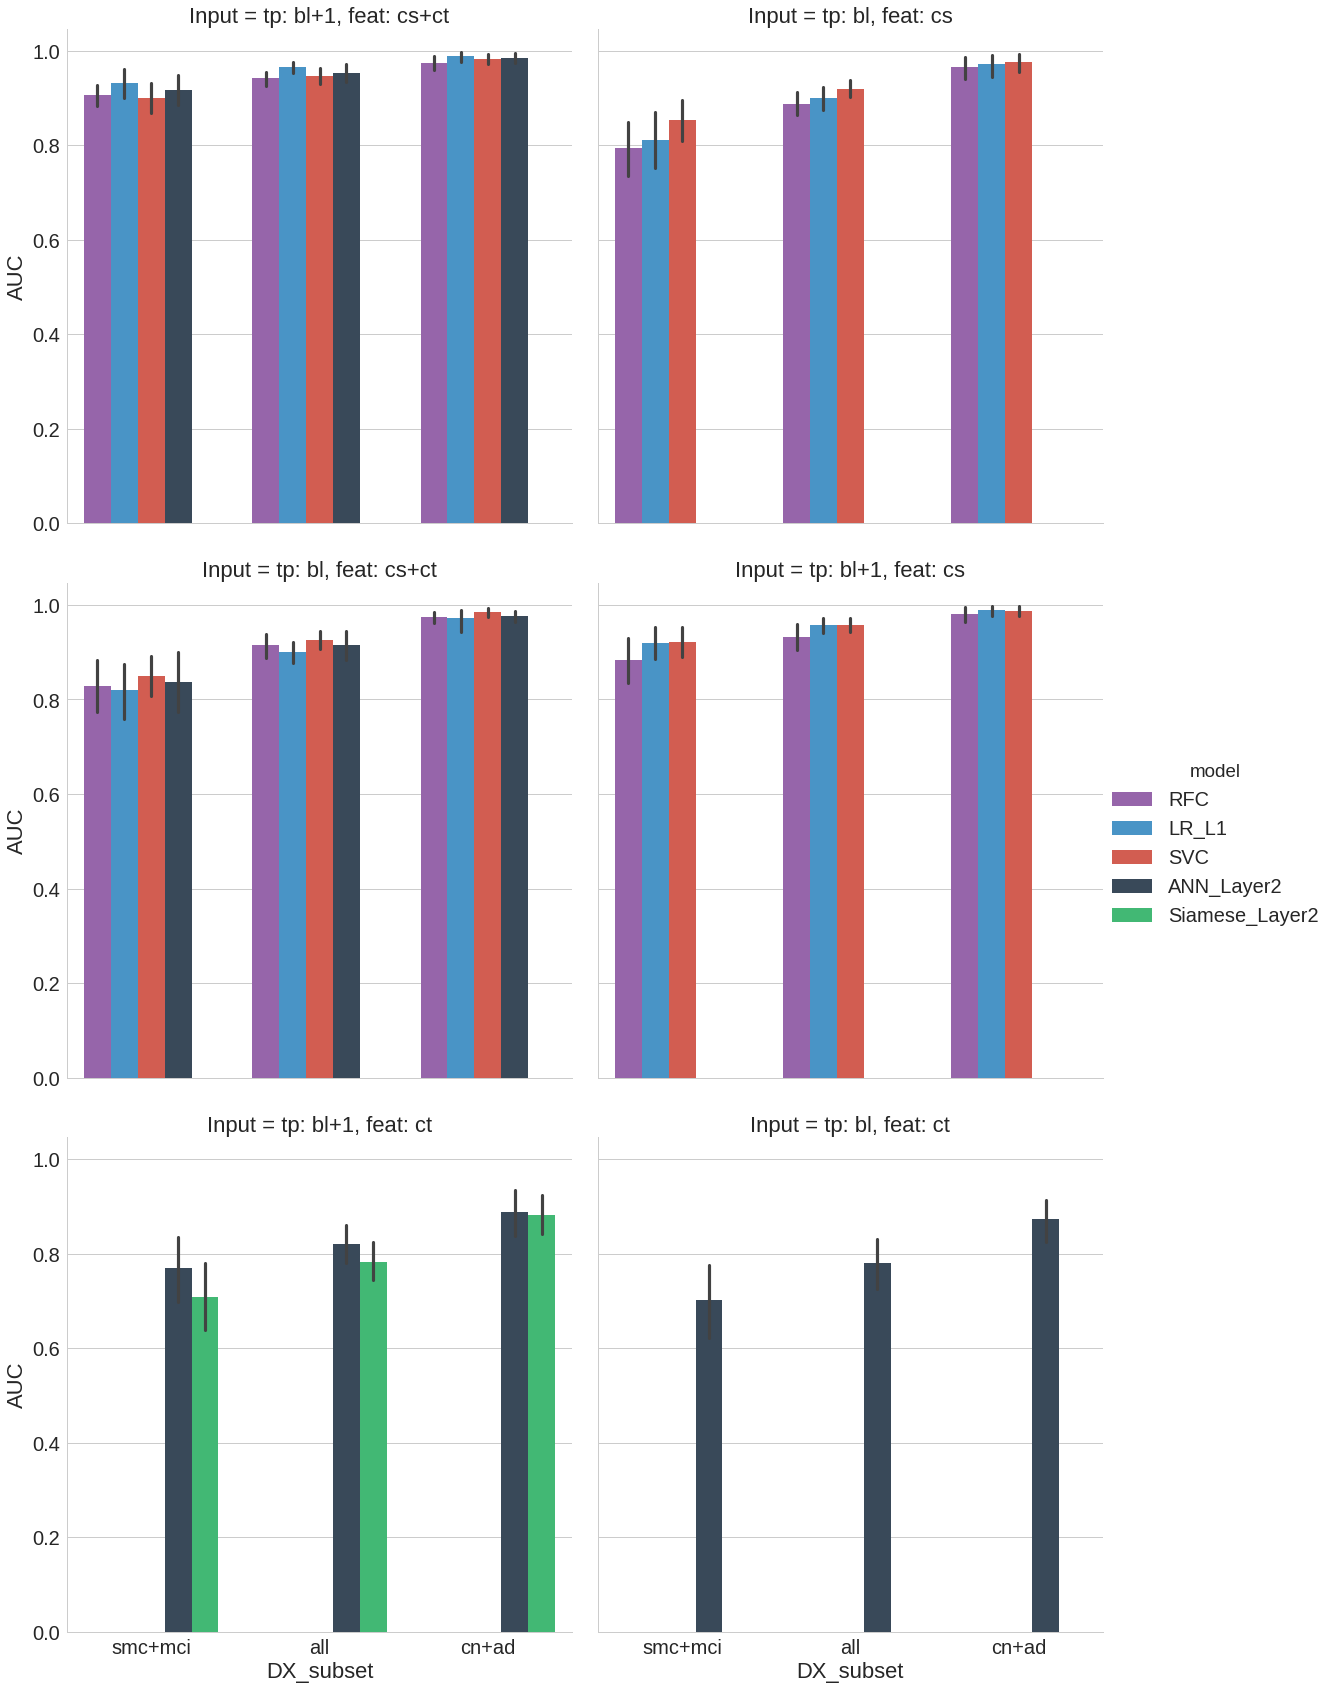

In [213]:
plt.rcParams['figure.figsize'] = (20, 20)
sns.set(font_scale=2)
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71", "#95a5a6"]
hue_order = ['tp: bl, feat: cs','tp: bl, feat: ct','tp: bl, feat: cs+ct',
             'tp: bl+1, feat: cs','tp: bl+1, feat: ct','tp: bl+1, feat: cs+ct']
with sns.axes_style("whitegrid"):
    g = sns.factorplot(y='AUC',x='DX_subset',col='Input',hue='model', data=CV_summary_df,
                       kind='bar',palette=flatui,size=8, col_wrap=2)

In [140]:
# PCA represenatations
from sklearn.decomposition import PCA

select_tp = 'var_tp'
exp_name = 'Exp_102_ADNI2_traj_MMSE_tp_' + select_tp
exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'
exp_setup = pickle.load( open(exp_setup_path, "rb" ) )
df = exp_setup['df']
kf = exp_setup['sKF']

cs_cols = ['MMSE_bl'] + demo_cols

if select_tp == 'var_tp':
    ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
    ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_rate')])
    ct_cols = ct_cols_bl + ct_cols_tp_rate
else:
    ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])

feat_cols = ct_cols

X_raw = np.array(df[feat_cols])
y = np.array(df['traj'])   

k=1
pca_df = pd.DataFrame()
for train, valid in kf:
    Sub_train = df['PTID'].values[train]
    Sub_valid = df['PTID'].values[valid]
    X_tr = X_raw[train]
    y_tr = y[train]
    X_te = X_raw[valid]
    y_te = y[valid]
   
    scaler = preprocessing.StandardScaler().fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_te = scaler.transform(X_te)
        
    #fit pca
    pca = PCA(n_components=2)
    pca.fit(X_tr)

    X_tr_pc = pca.transform(X_tr)
    X_te_pc = pca.transform(X_te)
    print 'Fold: {}, Explained_variance: {}'.format(k, pca.explained_variance_ratio_)

    pca_df_train = pd.DataFrame()
    pca_df_test = pd.DataFrame()
    pca_df_train['PTID'] = Sub_train
    pca_df_train['PC_1'] = X_tr_pc[:,0]
    pca_df_train['PC_2'] = X_tr_pc[:,1]
    pca_df_train['labels'] = y_tr
    pca_df_train['subset'] = np.tile('train',len(y_tr))
    pca_df_train['KF'] = np.tile(k,len(y_tr))
    
    pca_df_test['PTID'] = Sub_valid
    pca_df_test['PC_1'] = X_te_pc[:,0]
    pca_df_test['PC_2'] = X_te_pc[:,1]
    pca_df_test['labels'] = y_te
    pca_df_test['subset'] = np.tile('test',len(y_te))
    pca_df_test['KF'] = np.tile(k,len(y_te))
    pca_df_train = pca_df_train.append(pca_df_test)
    pca_df = pca_df.append(pca_df_train)
    
    k+=1
    
pca_df = pd.merge(pca_df,df_perf_dx_merge,on='PTID',how='inner')

Fold: 1, Explained_variance: [ 0.33064553  0.22106818]
Fold: 2, Explained_variance: [ 0.39670124  0.20320236]
Fold: 3, Explained_variance: [ 0.40398996  0.19477088]
Fold: 4, Explained_variance: [ 0.39780966  0.19837158]
Fold: 5, Explained_variance: [ 0.39773131  0.19890415]
Fold: 6, Explained_variance: [ 0.4030834   0.19899977]
Fold: 7, Explained_variance: [ 0.4035353   0.19754868]
Fold: 8, Explained_variance: [ 0.39315962  0.19925208]
Fold: 9, Explained_variance: [ 0.40258513  0.19281264]
Fold: 10, Explained_variance: [ 0.39255648  0.19566555]


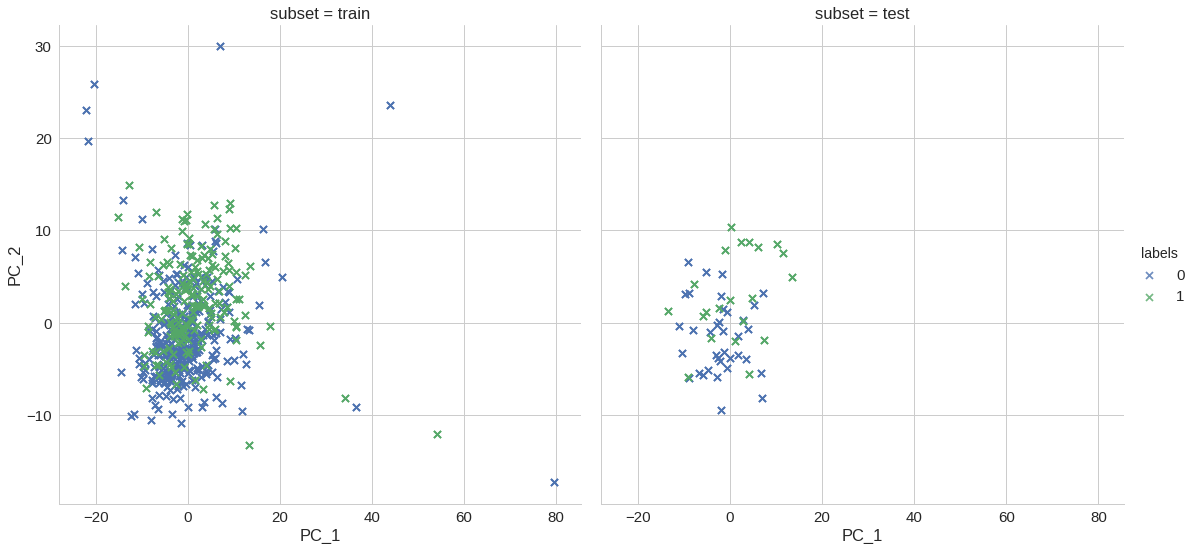

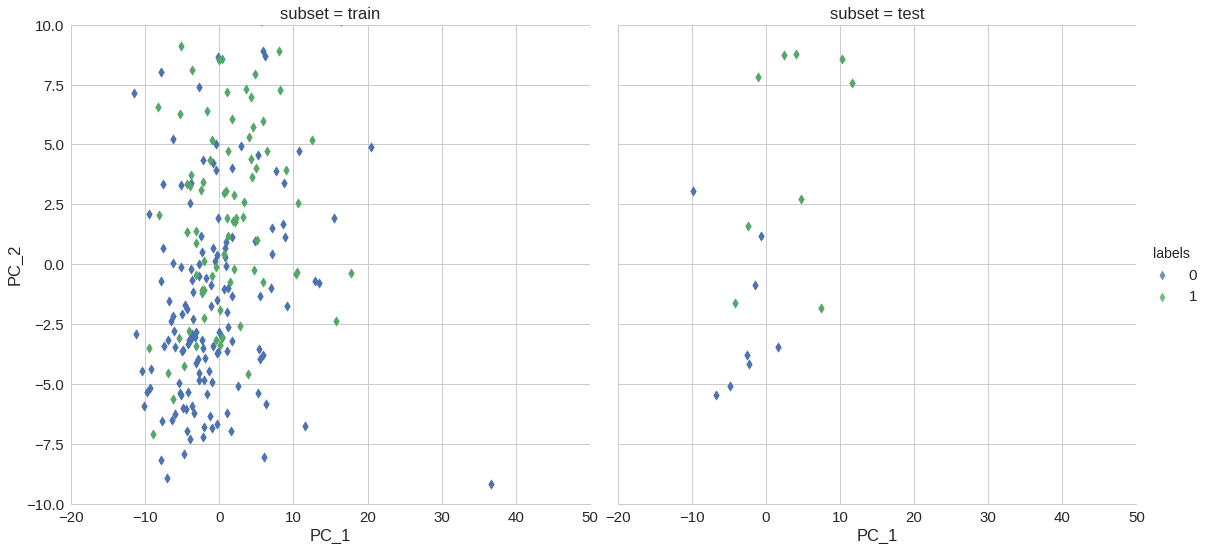

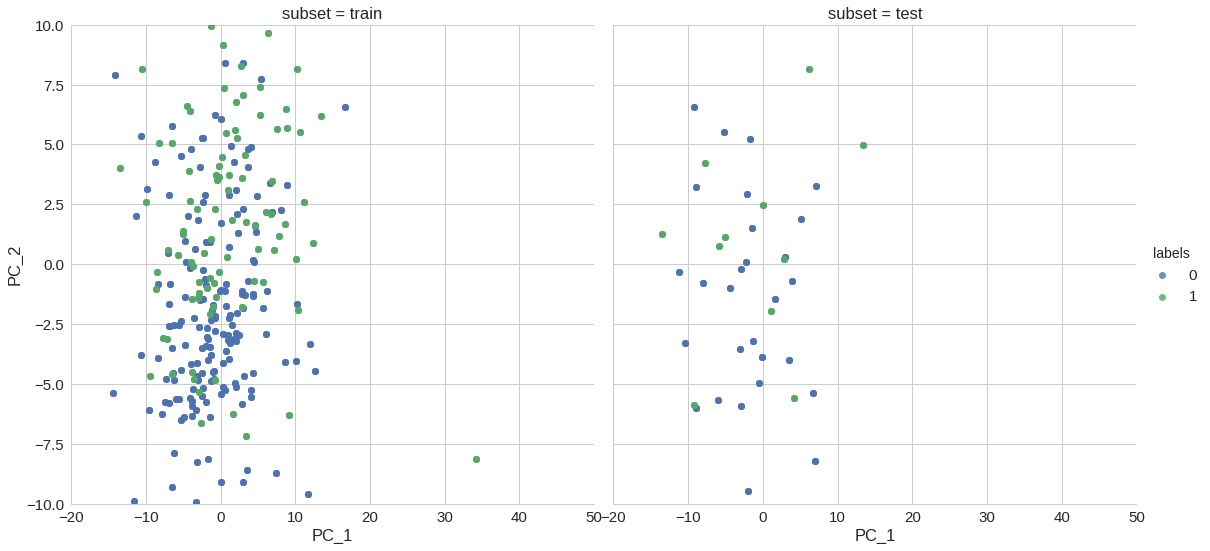

In [143]:
foldx = 5
sns.set(font_scale=1.5)
pca_df_all = pca_df[pca_df['KF']==foldx]
pca_df_adcn = pca_df[(pca_df['KF']==foldx)&(pca_df['DX_bl'].isin(['AD','CN']))]
pca_df_mci = pca_df[(pca_df['KF']==foldx)&(pca_df['DX_bl'].isin(['EMCI','LMCI','SMC']))]

with sns.axes_style("whitegrid"):
    g1 = sns.lmplot('PC_1','PC_2',fit_reg=False,hue='labels',col='subset',data=pca_df_all,markers='x',size=8)
    g2 = sns.lmplot('PC_1','PC_2',fit_reg=False,hue='labels',col='subset',data=pca_df_adcn,markers='d',size=8)
    g3 = sns.lmplot('PC_1','PC_2',fit_reg=False,hue='labels',col='subset',data=pca_df_mci,markers='o',size=8)
    #g1.axes[0,0].set_xlim(-20,50)
    #g1.axes[0,1].set_ylim(-10,10)
    g2.axes[0,0].set_xlim(-20,50)
    g2.axes[0,1].set_ylim(-10,10)
    g3.axes[0,0].set_xlim(-20,50)
    g3.axes[0,1].set_ylim(-10,10)

In [146]:
pca_df[(pca_df['KF']==foldx)&(pca_df['subset']=='test')]

,PTID,PC_1,PC_2,labels,subset,KF,model,kf,act_label,pred_label,pred_prob,DX_bl
4242,027_S_4873,0.231785,10.338666,1,test,5,LR_L1,5.0,1.0,1.0,"[0.00707469642902, 0.992925303571]",LMCI
4243,027_S_4873,0.231785,10.338666,1,test,5,SVC,5.0,1.0,1.0,"[0.0153619625471, 0.984638037453]",LMCI
4244,027_S_4873,0.231785,10.338666,1,test,5,RFC,5.0,1.0,1.0,"[0.0363268695209, 0.963673130479]",LMCI
4332,027_S_4936,4.106057,-5.584748,1,test,5,LR_L1,5.0,1.0,1.0,"[0.349196031805, 0.650803968195]",LMCI
4333,027_S_4936,4.106057,-5.584748,1,test,5,SVC,5.0,1.0,1.0,"[0.5, 0.5]",LMCI
4334,027_S_4936,4.106057,-5.584748,1,test,5,RFC,5.0,1.0,1.0,"[0.119669319966, 0.880330680034]",LMCI
4362,027_S_4938,10.216625,8.563249,1,test,5,LR_L1,5.0,1.0,1.0,"[0.00669735336448, 0.993302646636]",AD
4363,027_S_4938,10.216625,8.563249,1,test,5,SVC,5.0,1.0,1.0,"[0.0100708274401, 0.98992917256]",AD
4364,027_S_4938,10.216625,8.563249,1,test,5,RFC,5.0,1.0,1.0,"[0.0, 1.0]",AD
4392,027_S_4955,1.061041,-1.939150,1,test,5,LR_L1,5.0,1.0,1.0,"[0.00558251531973, 0.99441748468]",LMCI


In [111]:
#ROC curves
#exp_name = 'Exp_101_ADNI2_traj_MMSE_tp_bl'
#feat_sufix= '_CS_CT'

#Load perf_data
exp_perf_path = baseline_dir + 'perf_stats/df_perf_dict_{}_feat{}.pkl'.format(exp_name,feat_sufix)  
exp_perf = pickle.load( open(exp_perf_path, "rb" ) )
df_perf = pd.DataFrame.from_dict(exp_perf,orient='index')

marker_list = ['o','d','s','<','^','>','D','*','H']
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (10, 10)

mk=0

for model_choice in ['LR_L1','SVC','RFC']:
    df = df_perf[(df_perf.model_choice==model_choice)]
    CV_fpr_tpr = []
    CV_fpr_tpr_thrsh = []
    for y_act, y_pred_prob in zip(df['act_scores'].values,df['pred_prob'].values):
        fpr, tpr, thresholds = roc_curve(y_act, y_pred_prob[:,1]) 
        CV_fpr_tpr.append((fpr,tpr))        
        CV_fpr_tpr_thrsh.append(thresholds)

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (fpr, tpr) in enumerate(CV_fpr_tpr):
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)

    mean_tpr /= len(CV_fpr_tpr)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)



    with sns.axes_style("whitegrid"):
        label_str = '{}{}, mean ROC (area = {:3.2f})'.format(model_choice, feat_sufix, mean_auc)
        plt.plot(mean_fpr, mean_tpr, label=label_str, lw=4, marker = marker_list[mk],markersize=5)                    
        mk+=1

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate',fontsize = 20)
plt.title('Receiver operating characteristic',fontsize = 20)
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck', lw=4)
plt.legend(loc="lower right",fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

save_figure = False
fig_name = 'perf_stats/{}_feat{}_AUC.png'.format(exp_name,feat_sufix)
print 'saving fig at: {}'.format(baseline_dir + fig_name)
if save_figure:    
    plt.savefig(baseline_dir + fig_name, dpi=1000) 
    


IOError: [Errno 2] No such file or directory: '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/perf_stats/df_perf_dict_Exp_101_ADNI2_traj_MMSE_tp_bl_feat_CS_CT.pkl'

In [193]:
perf_df = df_perf_dx_merge
dx_list = ['AD','CN','LMCI']
df_dx_subset = perf_df[(perf_df['DX_bl'].isin(dx_list))&(perf_df['kf']==k)&(perf_df['model']==model_choice)]            
np.vstack(df_dx_subset['pred_prob'].values)

ValueError: need at least one array to concatenate

In [207]:
set(perf_df.kf.values)

{1, 2, 3}